In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('dqlab_telco_final.csv')
df.Churn = df.Churn.map({"No":0, "Yes":1})
df_backup = df.copy(deep=True)
df.drop(columns=["UpdatedAt","customerID"], inplace=True)
df.head()

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,0
1,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,0
2,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,1
3,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,0
4,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,0



    UpdatedAt        = Periode of Data taken
    customerID       = Customer ID
    gender           = Whether the customer is a male or a female (Male, Female)
    SeniorCitizen    = Whether the customer is a senior citizen or not (Yes, No)
    Partner          = Whether the customer has a partner or not (Yes, No)
    tenure           = Number of months the customer has stayed with the company
    PhoneService     = Whether the customer has a phone service or not (Yes, No)
    InternetService  =  Customer’s internet service provider (Yes, No)
    StreamingTV      = Whether the customer has streaming TV or not (Yes, No)
    PaperlessBilling = Whether the customer has paperless billing or not (Yes, No)
    MonthlyCharges   = The amount charged to the customer monthly
    TotalCharges     = The total amount charged to the customer
    Churn            = Whether the customer churned or not (Yes, No)


In [3]:
num_feature = ["tenure","MonthlyCharges","TotalCharges"]
cat_feature = df.drop(columns=num_feature).columns.to_list()[0:-1]
print("num_feature : ", num_feature)
print("cat_feature : ", cat_feature)

num_feature :  ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_feature :  ['gender', 'SeniorCitizen', 'Partner', 'PhoneService', 'StreamingTV', 'InternetService', 'PaperlessBilling']


### EDA

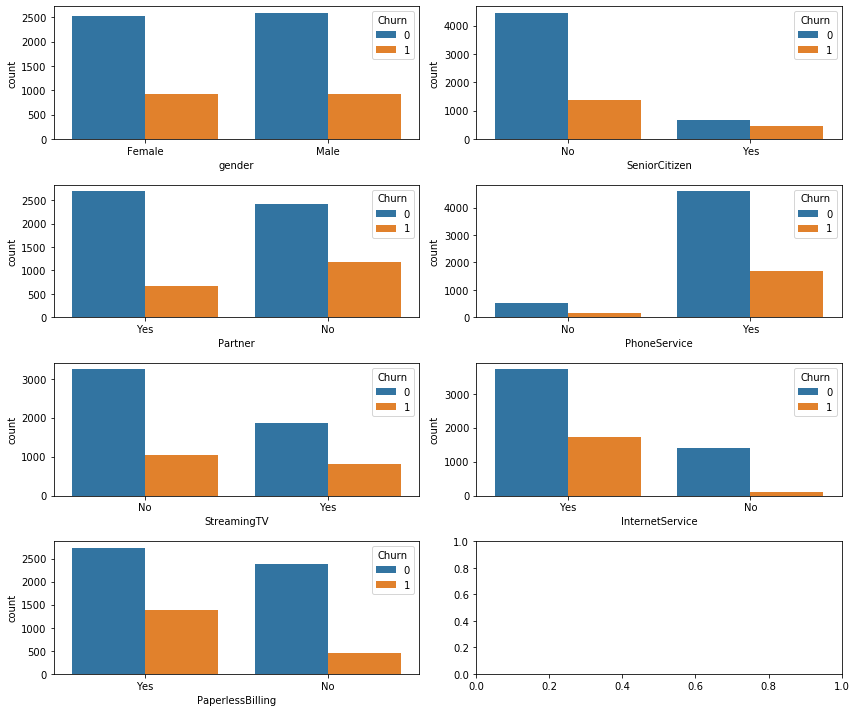

In [4]:
fig, ax = plt.subplots(4,2)
fig.set_size_inches(12,10)
rows=0
cols=0
for idx in range(8):
    try:
        sns.countplot(x=cat_feature[idx], hue="Churn", data=df, ax=ax[rows][cols])
        cols+=1
    except Exception as e:
        pass
    if cols>1:
        rows+=1
        cols=0

plt.tight_layout()
plt.show()

C:\Users\WIN10\miniconda3\envs\jcopml\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


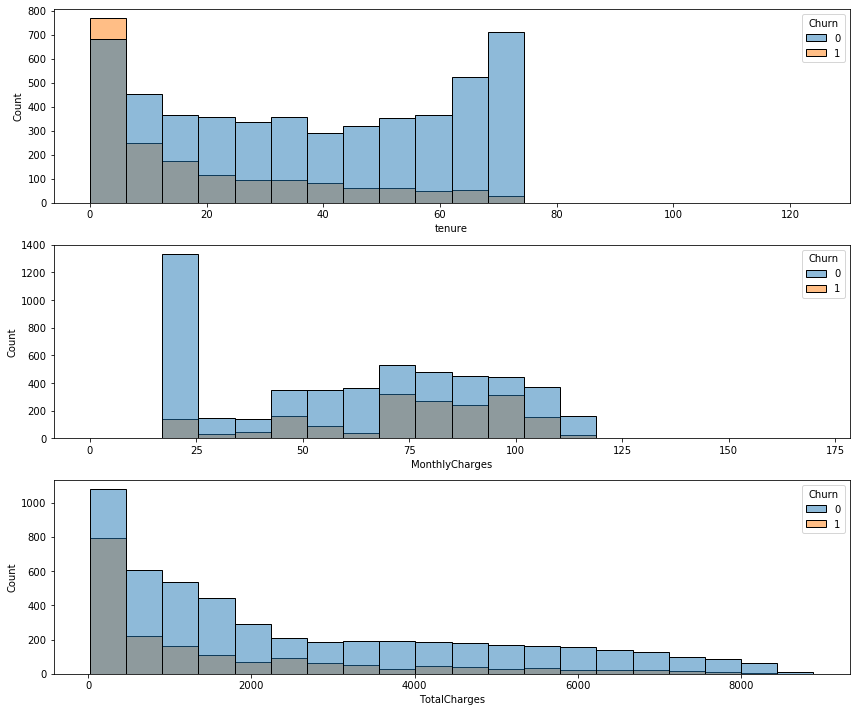

In [5]:
fig, ax = plt.subplots(3)
fig.set_size_inches(12,10)
rows=0
for num in num_feature:
    sns.histplot(data=df, x=num, hue="Churn", ax=ax[rows], bins=20, )
    rows+=1
fig.tight_layout()
fig.show()

In [13]:
feature = ["SeniorCitizen", "Partner",
           "InternetService", "PaperlessBilling",
           "PhoneService","tenure","MonthlyCharges"]

In [6]:
df.MonthlyCharges = pd.cut(df.MonthlyCharges, bins=[0,25,50,75,100,10000], labels=["Rendah","Cukup Rendah", "Sedang","Tinggi","Sangat Tinggi"])
df.head()

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,1,No,No,Yes,Yes,Cukup Rendah,29.85,0
1,Male,No,Yes,60,Yes,No,No,Yes,Rendah,1198.80,0
2,Male,No,No,5,Yes,Yes,Yes,No,Sangat Tinggi,541.90,1
3,Female,No,Yes,72,Yes,Yes,Yes,Yes,Sangat Tinggi,8312.75,0
4,Female,No,Yes,56,Yes,Yes,Yes,No,Tinggi,4620.40,0


In [8]:
df.tenure = pd.cut(df.tenure, bins=[0,20,40,60,10000], labels=["Singkat","Cukup Lama","Lama","Sangat Lama|"])
df.head()

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,Singkat,No,No,Yes,Yes,Cukup Rendah,29.85,0
1,Male,No,Yes,Lama,Yes,No,No,Yes,Rendah,1198.80,0
2,Male,No,No,Singkat,Yes,Yes,Yes,No,Sangat Tinggi,541.90,1
3,Female,No,Yes,Sangat Lama|,Yes,Yes,Yes,Yes,Sangat Tinggi,8312.75,0
4,Female,No,Yes,Lama,Yes,Yes,Yes,No,Tinggi,4620.40,0


In [12]:
num_feature[:-1], cat_feature

(['tenure', 'MonthlyCharges'],
 ['gender',
  'SeniorCitizen',
  'Partner',
  'PhoneService',
  'StreamingTV',
  'InternetService',
  'PaperlessBilling'])

In [15]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from jcopml.plot import plot_classification_report, plot_confusion_matrix, plot_roc_curve, plot_pr_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [27]:
X = df.drop(columns="Churn")
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5560, 10), (1390, 10), (5560,), (1390,))

In [28]:
X_train

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges
2182,Male,No,No,Singkat,Yes,Yes,Yes,Yes,Tinggi,1064.95
3854,Male,No,Yes,Cukup Lama,Yes,Yes,Yes,Yes,Tinggi,3204.65
3465,Male,No,No,Singkat,Yes,Yes,Yes,Yes,Sangat Tinggi,1553.95
4830,Male,No,No,Lama,Yes,No,No,Yes,Rendah,1266.40
5622,Female,No,No,Singkat,Yes,No,Yes,No,Sedang,220.65
...,...,...,...,...,...,...,...,...,...,...
4477,Male,No,No,Singkat,Yes,No,Yes,Yes,Cukup Rendah,518.90
1514,Male,No,Yes,Singkat,Yes,No,No,No,Rendah,343.60
3496,Female,No,No,Lama,Yes,No,No,No,Rendah,1505.05
1384,Female,No,Yes,Singkat,Yes,No,Yes,Yes,Tinggi,256.60


In [45]:
new_cat_feature = X_train.columns.to_list()
new_cat_feature.remove('TotalCharges')
new_cat_feature

['gender',
 'SeniorCitizen',
 'Partner',
 'tenure',
 'PhoneService',
 'StreamingTV',
 'InternetService',
 'PaperlessBilling',
 'MonthlyCharges']

In [46]:
preprocessor = ColumnTransformer([
    ('categoric', cat_pipe(encoder='ordinal'), new_cat_feature[1:]),
    ('categoric2', cat_pipe(encoder='onehot'), ["gender"])
])
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring='f1', n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.7s finished


{'algo__colsample_bytree': 0.5054493267725888, 'algo__gamma': 2, 'algo__learning_rate': 0.7902619549708234, 'algo__max_depth': 2, 'algo__n_estimators': 108, 'algo__reg_alpha': 0.0011584172310543986, 'algo__reg_lambda': 0.008386394780402564, 'algo__subsample': 0.42051273301300585}
0.4857990674014413 0.518116436980669 0.45799011532125206
